# Answer 3

The script below reads a pileup file, removes the indels and mapping qualities from the sequence pile, leaving just the matches/mismatches of the reads, and calculates the quality of each base. Only bases with a quailty of 40 or higher are used to determine the sequence coverage, and only reads with a calculated coverage between 5 and 99 inclusive are kept. For the remaining reads a consensus base is called if one base makes up 80% or more of the sequence. Otherwise, if a sequence has competing bases, none of which makes up 80% of the population, the read is ignored and no consensus base is called.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re

In [2]:
def recover_bases(pile):
    """
    Parse sequence pile to ignore mapping qualities
    and indels. Return sequence of just matches/mismatches.
    """
    
    # Remove $ and ^x from string
    pile = re.sub(r"\^.", "", pile.replace("$", ""))
    
    # Remove indels from string (none in demo data)
    pile = re.sub(r"\+\d+[ACGT]+", "", pile)
    pile = re.sub(r"\-\d+[ACGT]+", "", pile)
    
    return pile

**Read in pileup data**

In [3]:
with open("../../data/question_003/pileup/BL6_x_Cast_RNA.pileup", "r") as f:
    pileup_data = [line.split("\t") for line in f]

Store reference chromosome, reference position, and consensus base if:

* The sequence coverage of quality base reads is greater than or equal to 5X and less than 100X


* Mismatches relative to the reference is greater than or equal to 80% of the total number of bases in the pile

All other reads are ignored.


In [4]:
results = []

for entry in pileup_data[:]:

    reference_chromosome = entry[0].strip()
    reference_position = int(entry[1].strip())
    reference_base = entry[2].strip()
    sequence_pile = recover_bases(entry[4].strip())
    sequence_quality = entry[5].strip()
        
    # Exclude bases with quality score less than 40
    pile_quality_zipped =  zip(list(sequence_pile),
                               [ord(q) - 33 for q in sequence_quality])
    
    zipped_filtered = [x for x in pile_quality_zipped if x[1] >= 40]
    
    if zipped_filtered:
        # Reconstruct sequence
        bases_filtered = "".join([x[0].upper() for x in zipped_filtered])
        
        # Calculate sequence coverage only from bases with high quality
        sequence_coverage = len(bases_filtered)
        
        # Skip entry if coverage less than 5 or greater than/equal to 100
        if sequence_coverage < 5 or sequence_coverage >= 100:
            continue
        
        # If sequence all the same base, add consensus base to results
        if len(set(bases_filtered)) == 1:
            results.append({
                    "reference_chromosome": reference_chromosome,
                    "reference_position": reference_position,
                    "consensus_base": bases_filtered[0]
                })
        else:
            # Calculate if base is more than 80% of sequence
            base_count = {base for base in set(bases_filtered) 
                          if bases_filtered.count(base) 
                          / len(bases_filtered) >= 0.80}
            # Add consensus sequence to results if it is
            if base_count:
                results.append({
                    "reference_chromosome": reference_chromosome,
                    "reference_position": reference_position,
                    "consensus_base":  list(base_count)[0]
                })

In [5]:
consensus_bases = pd.DataFrame(results)

**Print reads with a consensus base**

In [6]:
consensus_bases[["reference_chromosome", "reference_position", "consensus_base"]]

,reference_chromosome,reference_position,consensus_base
0,chr7,147526773,G
1,chr7,147526774,T
2,chr7,147526775,T
3,chr7,147526776,T
4,chr7,147526777,G
5,chr7,147526778,T
6,chr7,147526779,A
7,chr7,147526780,G
8,chr7,147526781,G
9,chr7,147526782,C


**Export to TSV**

In [7]:
consensus_bases.to_csv("consensus_bases.tsv", sep="\t")

**Visualize base calling results**

Shown are the consensus bases, as well as the reads that were excluded for various reasons (outside coverage range, insufficient quality, conflicting bases):

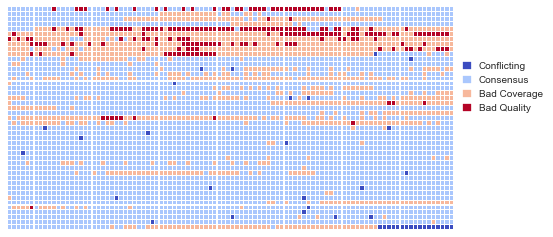

In [10]:
create_visualization().show()

**Visualization code**

*Code below slight variation of the above. Generates data to create visualization. Function that creates the visualization is below that. Cell must be run before above.*

In [11]:
def create_visualization_data():
    
    results = []

    for entry in pileup_data[:]:

        reference_chromosome = entry[0].strip()
        reference_position = int(entry[1].strip())
        reference_base = entry[2].strip()
        sequence_pile = recover_bases(entry[4].strip())
        sequence_quality = entry[5].strip()

        # Exclude bases with quality score less than 40
        pile_quality_zipped =  zip(list(sequence_pile),
                                   [ord(q) - 33 for q in sequence_quality])

        zipped_filtered = [x for x in pile_quality_zipped if x[1] >= 40]

        if not zipped_filtered:
            results.append({
                        "reference_chromosome": reference_chromosome,
                        "reference_position": reference_position,
                        "consensus_base":  "d_bad_quality"
                    })
        else:
            # Reconstruct sequence
            bases_filtered = "".join([x[0].upper() for x in zipped_filtered])

            # Calculate sequence coverage only from bases with high quality
            sequence_coverage = len(bases_filtered)

            # Skip entry if coverage less than 5 or greater than/equal to 100
            if sequence_coverage < 5 or sequence_coverage >= 100:
                results.append({
                        "reference_chromosome": reference_chromosome,
                        "reference_position": reference_position,
                        "consensus_base":  "c_bad_coverage"
                    })
                continue

            # If sequence all the same base, add consensus base to results
            if len(set(bases_filtered)) == 1:
                results.append({
                        "reference_chromosome": reference_chromosome,
                        "reference_position": reference_position,
                        "consensus_base": "b_consensus"
                    })
            else:
                # Calculate if base is more than 80% of sequence
                base_count = {base for base in set(bases_filtered) 
                              if bases_filtered.count(base) 
                              / len(bases_filtered) >= 0.80}
                # Add consensus sequence to results if it is
                if not base_count:
                    results.append({
                        "reference_chromosome": reference_chromosome,
                        "reference_position": reference_position,
                        "consensus_base":  "a_conflicting_bases"
                    })
                else:
                    results.append({
                        "reference_chromosome": reference_chromosome,
                        "reference_position": reference_position,
                        "consensus_base":  "b_consensus"
                    })
                    
    return results

def create_visualization():
    results = create_visualization_data()
    consensus_bases = pd.DataFrame(results)[["reference_chromosome", "reference_position", "consensus_base"]]
    data = consensus_bases["consensus_base"].astype('category').cat.codes.values
    data = np.append(data, np.zeros(100 - (len(data) % 100)))
    data = data.reshape(-1, 100)

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)

    heatmap = sns.heatmap(data,
                          cmap="coolwarm",
                          cbar=False,
                          linewidths=0.07,
                          yticklabels=False,
                          xticklabels=False,
                          ax=ax)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])

    legend_ax = fig.add_axes([0.9, 0.5, 0.1, 0.1])
    legend_ax.axis('off')

    label_size = len(consensus_bases["consensus_base"].unique())
    labels = ["Conflicting", "Consensus", "Bad Coverage", "Bad Quality"]

    colors = plt.cm.coolwarm(np.linspace(0, 1, label_size))
    patches = [mpatches.Patch(facecolor=c, edgecolor=c) for c in colors]

    legend = legend_ax.legend(patches,
                              labels,
                              handlelength=0.8,
                              loc='lower left',
                              fontsize=10)

    for label in legend.get_texts():
        label.set_ha("left")

    return plt